# Predicting Recessions with LSTM Machine Learning Model

## Loading Libraries and Datasets

In [1]:
#Import libraries for ML/data cleaning/visualization
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#Use seaborn theme on matplotlib library
sns.set_theme()

In [2]:
#Set file path for easy import
import os
os.chdir('/home/jovyan/RecessionPrediction')
print(os.getcwd())

/home/jovyan/RecessionPrediction


In [3]:
#Import datasets downloaded from FRED website
#Daily recordings of yield curve, difference between interest rates on short and long term government bonds
yield_curve = pd.read_csv('10Y3MYield.csv')
yield_curve = yield_curve.rename(columns={"T10Y3M": "spread"})
yield_curve.head()

,observation_date,spread
0,1982-01-04,2.32
1,1982-01-05,2.24
2,1982-01-06,2.43
3,1982-01-07,2.46
4,1982-01-08,2.50


In [4]:
#Daily recordings of % change in oil prices from a year ago
oil = pd.read_csv('DCOILWTICO_PC1.csv')
oil = oil.rename(columns={"DCOILWTICO_PC1": "oil_change"})
oil.head()

,observation_date,oil_change
0,1987-01-02,-30.26923
1,1987-01-05,-32.22767
2,1987-01-06,-29.55513
3,1987-01-07,-29.33900
4,1987-01-08,-28.42874


In [5]:
#Daily recordings of % change in stock prices from a year ago
stocks = pd.read_csv('NASDAQCOM_PC1.csv')
stocks = stocks.rename(columns={"NASDAQCOM_PC1": "stock_change"})
stocks.head()

,observation_date,stock_change
0,1972-02-04,21.24000
1,1972-02-07,20.13090
2,1972-02-08,20.43470
3,1972-02-09,21.32287
4,1972-02-10,20.95614


## Merging and Cleaning Data

In [6]:
#Convert date recordings from each table to datetime format for ease of filtering
yield_curve['observation_date'] = pd.to_datetime(yield_curve['observation_date'])
oil['observation_date'] = pd.to_datetime(oil['observation_date'])
stocks['observation_date'] = pd.to_datetime(stocks['observation_date'])

In [7]:
#Merge together the three filters on basis of shared date of recording
features = pd.merge(yield_curve, oil, on = 'observation_date', how = 'inner').merge(stocks, on = 'observation_date')
features = features.rename(columns={"observation_date": "date"})

#Some recordings of oil_change and stock_change are NaN values, drop them with .dropna() method
features.dropna(inplace = True)
features.head()

,date,spread,oil_change,stock_change
0,1987-01-02,1.48,-30.26923,8.45511
1,1987-01-05,1.37,-32.22767,10.79788
2,1987-01-06,1.41,-29.55513,11.00261
3,1987-01-07,1.47,-29.33900,13.53287
4,1987-01-08,1.46,-28.42874,16.88183


<Axes: xlabel='date'>

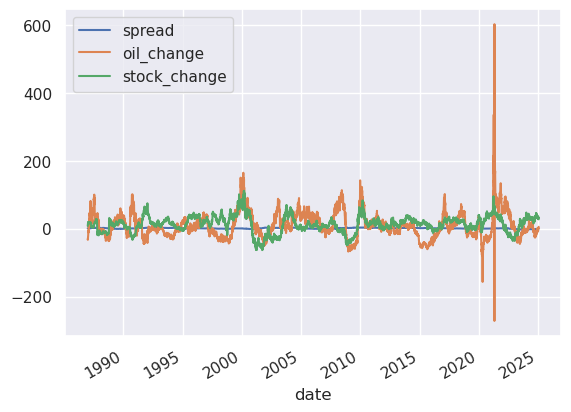

In [8]:
#Plot 3 features together
#We can see oil_change and stock_change tend toward more extreme values
#Also observe some co-movement in oil_change and stock_change data, which decreases their predictive power
features.set_index('date').plot(y = ['spread', 'oil_change', 'stock_change'])

In [9]:
#Write function to tell if economy is in recession a year from a given date
#Will output binary values, 1 for future recession, 0 for no future recession

def in_recession(date):
    date = pd.Timestamp(date)
    if date in pd.date_range(start='1988-10-01', end='1990-04-01'):
        return 1
    elif date in pd.date_range(start='2000-01-01', end='2000-07-01'):
        return 1
    elif date in pd.date_range(start='2006-10-01', end='2008-04-01'): 
        return 1
    elif date in pd.date_range(start='2019-01-01', end='2019-07-01'):
        return 1
    else:
        return 0

In [10]:
#Generate observations using dates in features table
recession = features['date'].apply(in_recession)

In [11]:
#Create table joined, which includes features and binary recession variable (the target)
joined = features.copy()
joined['recession'] = recession
joined = joined[joined['date'] < '2024-03-01']
joined.tail()

,date,spread,oil_change,stock_change,recession
9690,2024-02-23,-1.20,1.85064,40.38529,0
9691,2024-02-26,-1.19,3.91690,39.32395,0
9692,2024-02-27,-1.14,3.79813,39.97856,0
9693,2024-02-28,-1.18,2.41073,40.14472,0
9694,2024-02-29,-1.20,1.49904,40.38165,0


In [12]:
len(joined)

9083

In [13]:
#Check sample date to ensure function was applied properly
joined[joined['date'] == '2019-01-02']

,date,spread,oil_change,stock_change,recession
8348,2019-01-02,0.24,-24.83363,-5.65549,1


In [14]:
#Check for correlation between features
joined['spread'].corr(joined['oil_change'])

0.014770678913113684

In [15]:
joined['spread'].corr(joined['stock_change'])

-0.06748541221537376

In [16]:
#Confirms changes in oil prices and stock prices are correlated with each other, decreases explanatory power
joined['oil_change'].corr(joined['stock_change'])

0.2656188547455323

## Create tensors, split data for modeling

In [17]:
#Split data into training and testing sets, based on chronological order of data
#For LSTM model, random split cannot be used as it will lead to leakage between train and test sets
train_size = int(0.8 * len(joined))
test_size = len(joined) - train_size
train, test = joined[:train_size], joined[train_size:]

In [18]:
#Create PyTorch tensors representing training and testing values of features and target variables
X_train, y_train = train[['spread', 'oil_change', 'stock_change']].values, train[['recession']].values
X_test, y_test = test[['spread', 'oil_change', 'stock_change']].values, test[['recession']].values
X_tensor_train, y_tensor_train = torch.tensor(X_train), torch.tensor(y_train)
X_tensor_test, y_tensor_test = torch.tensor(X_test), torch.tensor(y_test)
X_tensor_test

tensor([[ 1.4400,  1.7965, 11.4132],
        [ 1.4500,  2.5812, 12.7794],
        [ 1.4400, -2.6125, 13.2135],
        ...,
        [-1.1400,  3.7981, 39.9786],
        [-1.1800,  2.4107, 40.1447],
        [-1.2000,  1.4990, 40.3817]], dtype=torch.float64)

In [19]:
#Normalize train feature observations with sklearn MinMaxScaler class
#MinMaxScaler is suited for this data, as some features tend toward extreme values
#Use .unsqueeze(1) method to configure tensor dimensions for LSTM model
scaler_X = MinMaxScaler()
scaler_X.fit(X_tensor_train.numpy())
X_train_scaled = scaler_X.transform(X_tensor_train.numpy())
X_train_scaled = torch.tensor(X_train_scaled).float()
X_train_scaled = X_train_scaled.unsqueeze(1)
X_train_scaled

tensor([[[0.5041, 0.1579, 0.4069]],

        [[0.4813, 0.1495, 0.4203]],

        [[0.4896, 0.1610, 0.4215]],

        ...,

        [[0.4876, 0.2723, 0.4080]],

        [[0.4876, 0.2576, 0.4067]],

        [[0.4855, 0.2667, 0.4169]]])

In [20]:
#Repeat scaling process with test feature data
#Use .unsqueeze(1) method to configure tensor dimensions for LSTM model
X_test_scaled = scaler_X.transform(X_tensor_test.numpy())
X_test_scaled = torch.tensor(X_test_scaled).float()
X_test_scaled = X_test_scaled.unsqueeze(1)
X_test_scaled

tensor([[[ 0.4959,  0.2961,  0.4239]],

        [[ 0.4979,  0.2995,  0.4317]],

        [[ 0.4959,  0.2771,  0.4342]],

        ...,

        [[-0.0394,  0.3048,  0.5875]],

        [[-0.0477,  0.2988,  0.5885]],

        [[-0.0519,  0.2949,  0.5898]]])

In [21]:
#Check dimensions of each training and test tensor align
len(X_train_scaled), len(X_test_scaled), len(y_tensor_train), len(y_tensor_test)

(7266, 1817, 7266, 1817)

In [22]:
#Check that feature tensors are 3D, necessary for LSTM model
X_train_scaled.shape, X_test_scaled.shape

(torch.Size([7266, 1, 3]), torch.Size([1817, 1, 3]))

## Initialize LSTM model, neural network

In [23]:
#Create a LSTM neural network framework for the model
class LSTMModel(nn.Module): 
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = 3, hidden_size = 128, num_layers = 1, batch_first=True)
        self.fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        
        #Input layer has 3 neurons, one for each independent variable
        #Hidden size of 128 will detect complex patterns while hopefully mitigating overfitting
        #Output layer has 1 neuron for the single dependent variable
        #Use sigmoid activation function, as model meant to predict probabilites between 0 and 1
        
    #Define forward method, defines flow of data through LSTM model
    #x = x[:,-1,:] extracts the most updated prediction from the LSTM's hidden layer
    def forward(self, x): 
        x, _ = self.lstm(x)
        x = x[:,-1,:]
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


input_size = 3       # 3 independent variables
hidden_size = 128     # Number of LSTM cells (hidden units)
num_layers = 1       # 1-layer LSTM
output_size = 1      # 1 dependent variable

#Define model_0 as an instance of this class
model_0 = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [24]:
#Initialize loss and optimizer functions
#Choose BCELoss() function, ideal for binary probability prediction
#Choose torch.optim.Adam optimizer, better for faster convergence (low learning rate done to manage overfitting)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0001)

## Train and evaluate LSTM model

In [25]:
#Initialize batch size dataloaders to better manage model training 
#Start with small batch size value, like 100

from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_scaled, y_tensor_train)
test_dataset = TensorDataset(X_test_scaled, y_tensor_test)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [26]:
#Use 50 epochs, as I observed more typically lead to overfitting
epochs = 50

#Create empty lists to track loss values for visualization purposes
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    #Forward pass, calculate predictions/loss for training set
    model_0.train()
    train_loss = 0

    #Iterate through batches in train loader to update predictions and loss
    for X_batch, y_batch in train_loader:
        train_preds = model_0(X_batch.float())
        loss = loss_fn(train_preds.float(), y_batch.float())
        
        #Backward pass, minimizes loss using chosen optimizer/loss function
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    #Evaluation, set model to evaluate mode and calculate predictions/loss for test set
    model_0.eval()
    test_loss = 0
    with torch.inference_mode():
        #Iterate through batches in train loader to update predictions and loss
        for X_batch, y_batch in test_loader:
            test_pred = model_0(X_batch.float())
            test_loss += loss_fn(test_pred.float(), y_batch.type(torch.float))    
        test_loss /= len(test_loader)
        
    #Print out loss values every 12th epoch to monitor overfitting
    if epoch % 12 == 0 and epoch != 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | MSE Train Loss: {train_loss} | MSE Test Loss: {test_loss} ")

Epoch: 12 | MSE Train Loss: 0.4035315168638752 | MSE Test Loss: 0.3605765998363495 
Epoch: 24 | MSE Train Loss: 0.34144193913838633 | MSE Test Loss: 0.2752865254878998 
Epoch: 36 | MSE Train Loss: 0.33206588325843417 | MSE Test Loss: 0.2635830044746399 
Epoch: 48 | MSE Train Loss: 0.32596671025026336 | MSE Test Loss: 0.2629379332065582 


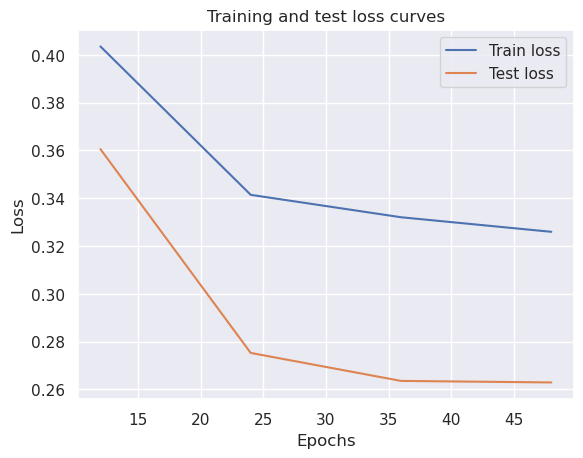

In [27]:
#Plot out training and testing loss curves against the number of epochs
#Test loss plateaus or increases after fairly few epochs; more hyperparameter tuning is needed
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Examine predictions on train and test sets

In [28]:
#Create new dataframe to visualize the model's performance on the train set against actual recession values
train_predictions = model_0(X_train_scaled)
train_graphing = train.copy().set_index('date')
train_graphing['train_predictions'] = train_predictions.detach().numpy()
train_graphing.head() 

,spread,oil_change,stock_change,recession,train_predictions
date,,,,,
1987-01-02,1.48,-30.26923,8.45511,0,0.118730
1987-01-05,1.37,-32.22767,10.79788,0,0.121618
1987-01-06,1.41,-29.55513,11.00261,0,0.119946
1987-01-07,1.47,-29.33900,13.53287,0,0.117415
1987-01-08,1.46,-28.42874,16.88183,0,0.116609


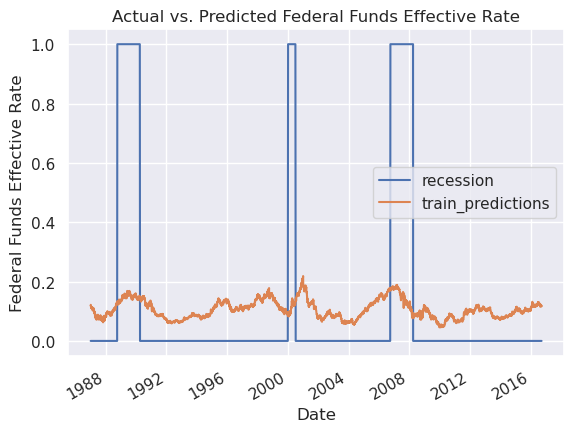

In [29]:
#Graphically examine the predictions the model makes on the training set
train_graphing.plot(y = ['recession', 'train_predictions'], use_index = True)
plt.xlabel('Date')
plt.ylabel('Federal Funds Effective Rate')
plt.title('Actual vs. Predicted Federal Funds Effective Rate')
plt.show()

In [30]:
#Create new dataframe to visualize the model's performance on the test set against actual recession values
predictions = model_0(X_test_scaled)
test_graphing = test.copy().set_index('date')
test_graphing['predictions'] = predictions.detach().numpy()
test_graphing.head()

,spread,oil_change,stock_change,recession,predictions
date,,,,,
2016-09-21,1.44,1.79654,11.41321,0,0.114156
2016-09-22,1.45,2.58122,12.77944,0,0.113370
2016-09-23,1.44,-2.61251,13.21349,0,0.114311
2016-09-26,1.34,2.70270,15.70257,0,0.115681
2016-09-27,1.30,-1.30416,17.45260,0,0.116953


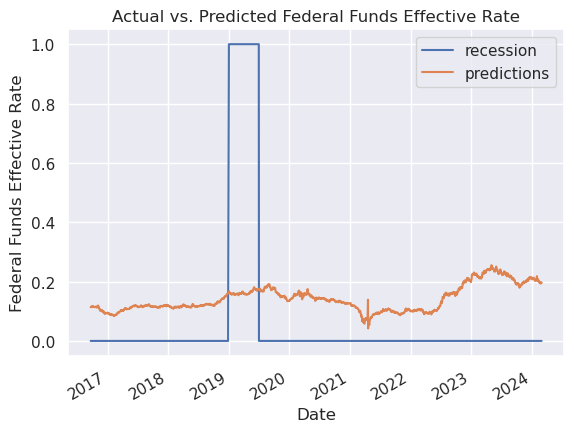

In [31]:
#Graphically examine the predictions the model makes on the training set
test_graphing.plot(y = ['recession', 'predictions'], use_index = True)
plt.xlabel('Date')
plt.ylabel('Federal Funds Effective Rate')
plt.title('Actual vs. Predicted Federal Funds Effective Rate')
plt.show()